# The SSR Under QR Heston

We use `QRH.blip` to compute the SSR under quadratic rough Heston by blipping.


In [1]:
# The required packages
library(gsl)
library(foreach)
library(doParallel)
library(colorspace)
library(MittagLeffleR)
library(statmod)
library(stinepack)
library(repr)


Warning message:
"package 'doParallel' was built under R version 4.0.5"
Loading required package: iterators

Loading required package: parallel



In [2]:
source("gamma_kernel.R")
source("qrh_gamma_y_from_xi.R")
source("qrh_simulation.R")
source("black_scholes.R")


In [3]:
bl <- "royalblue"
rd <- "red2"
pk <- "hotpink1"
gr <- "green4"
br <- "brown"
pu <- "purple"


In [4]:
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 150)


# Gamma kernel

The gamma kernel is given by $$ \kappa(\tau)= \frac{\nu}{\Gamma(\alpha)} \, \tau^{\alpha-1}\,e^{-\lambda \tau}, $$

with $\alpha = H + \tfrac12$.


In [5]:
params0 <- list(al = 0.568, lam = 9.68, nu = 0.572, c = 8.1e-3)


# Initial forward variance curve $\xi_t(u)$


In [6]:
load(file = "xi_20230215.rData")


In [7]:
xi <- xiCurveObj$getForwardVarCurve()


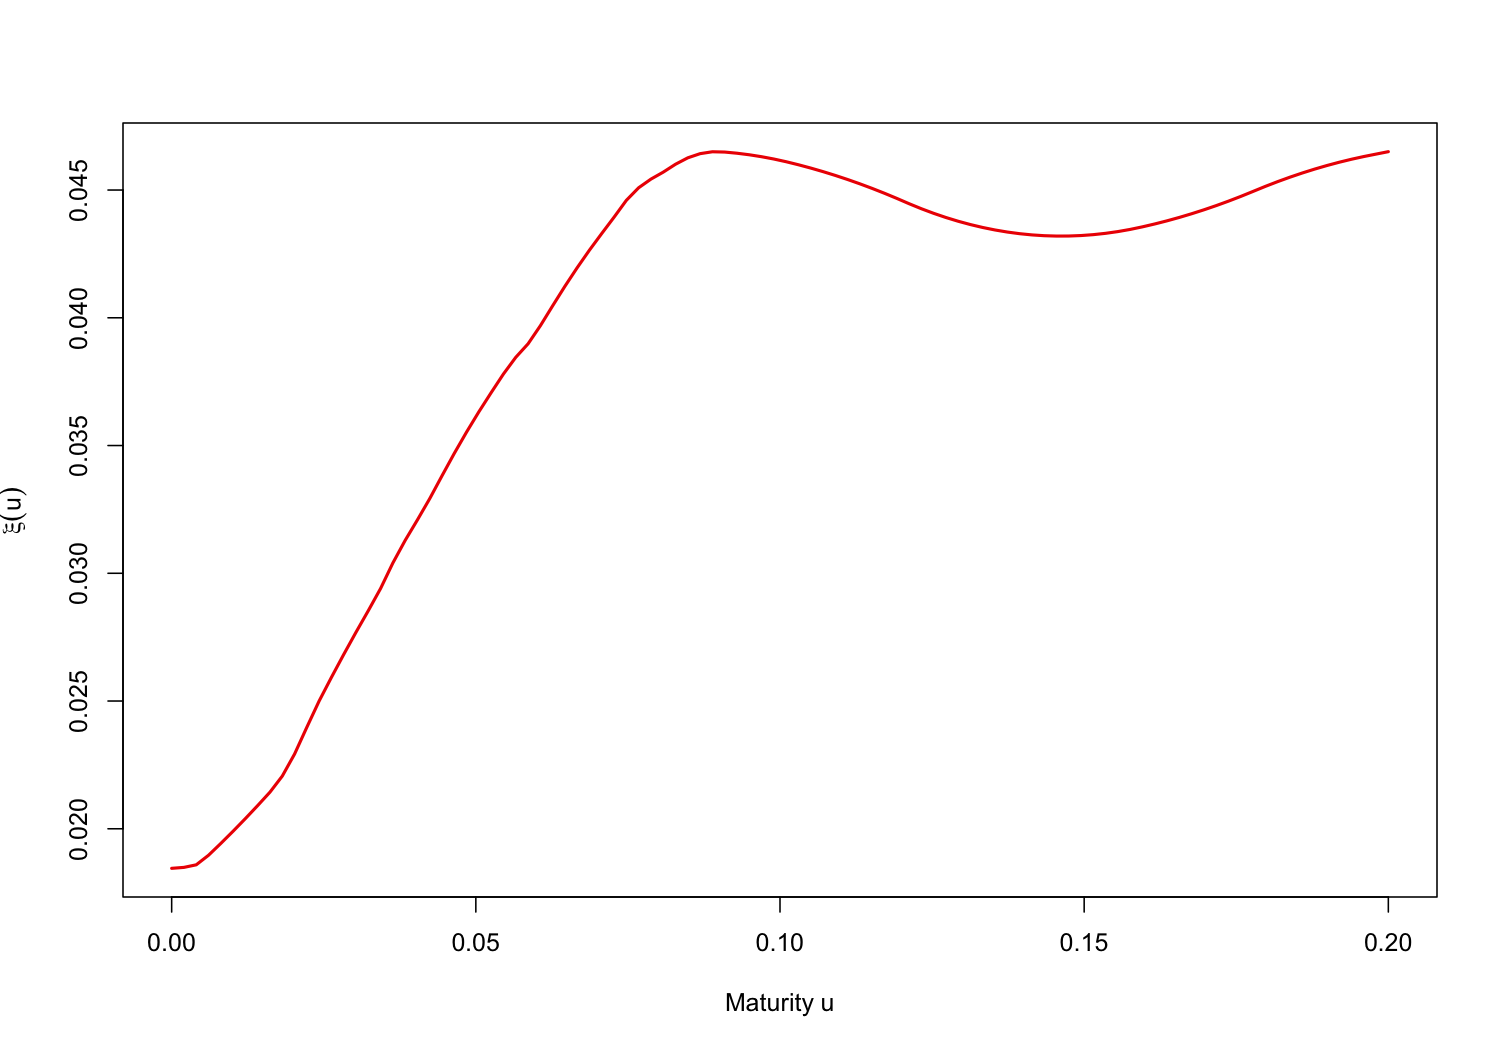

In [8]:
curve(xi,
  from = 0, to = .2, col = "red2", n = 100, lwd = 2,
  xlab = "Maturity u", ylab = expression(xi(u))
)


# $y_t(u)$ from $\xi_t(u)$

$$ y_t(u)^2= \xi_t(u) - c - \int_t^u\,\xi_t(s)\,\kappa (u-s)^2\,ds. $$


Integration is performed using Gauss-Jacobi quadrature.


In [9]:
ey <- yFromXi(params0, xi)


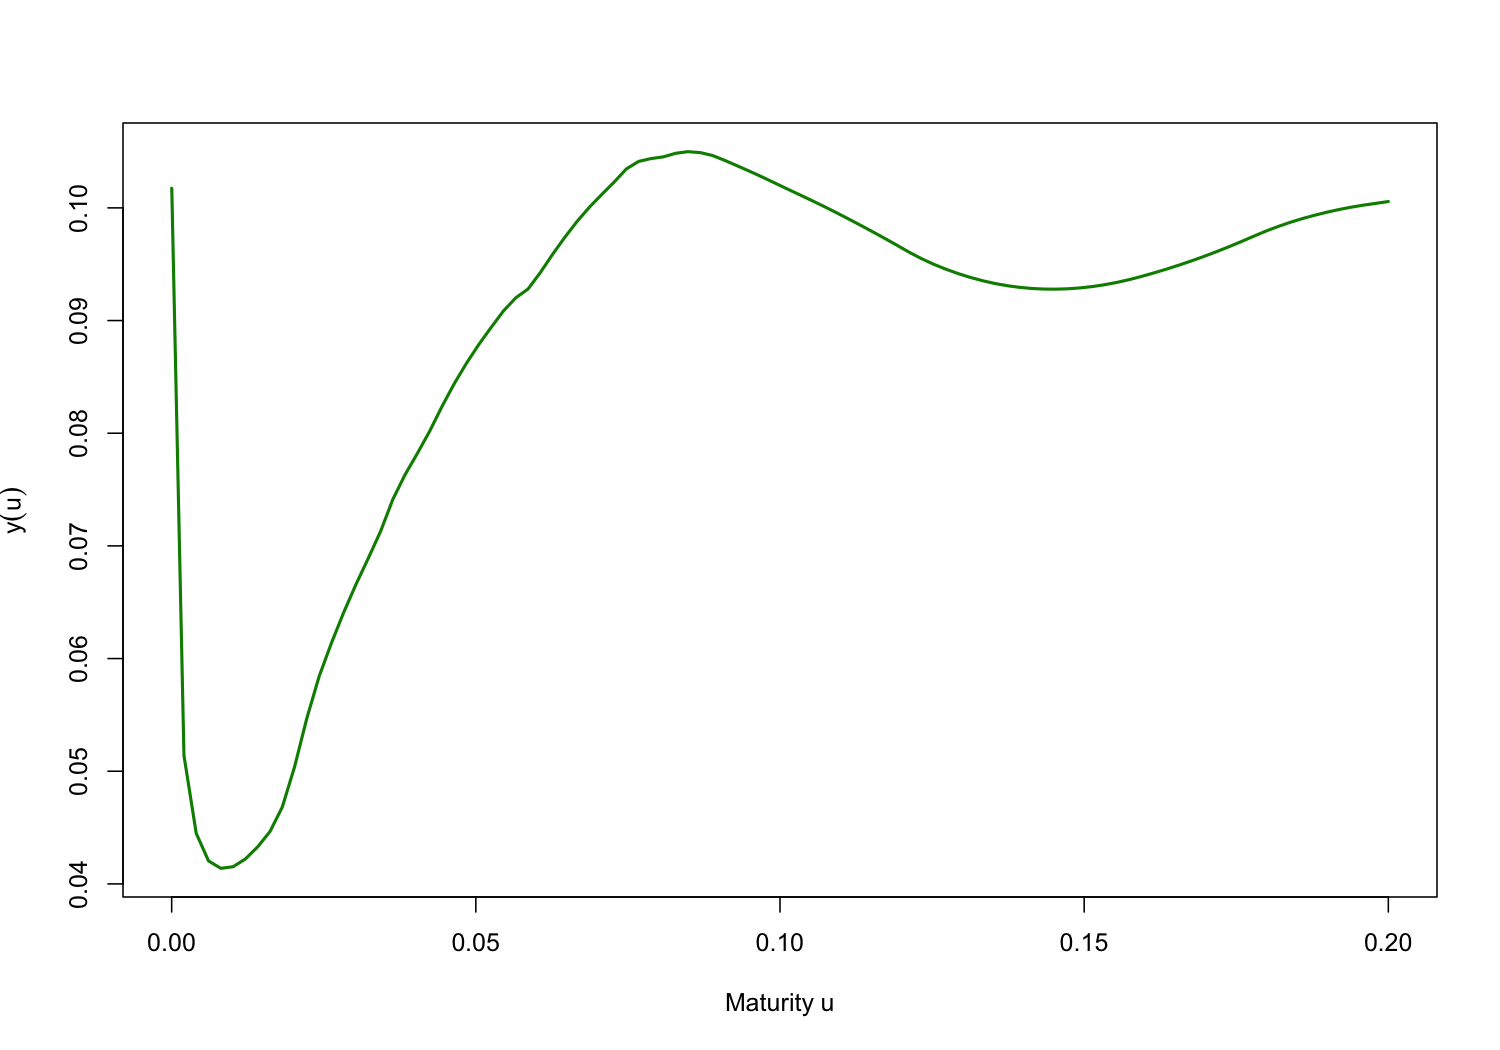

In [10]:
curve(ey,
  from = 0, to = .2, n = 100, col = "green4", lwd = 2,
  xlab = "Maturity u", ylab = expression(y(u))
)


# The SSR under quadratic rough Heston

Recall that in forward volatility form, the QR Heston model reads:

$$ dy_t(u) = \kappa(u-t)\,\sqrt{V_t}\,dW_t. $$

We may then apply the finite difference methodology of [Bourgey et al.](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4911186) to approximate the SSR. Specifically, the regression coefficient is given by

$$ \beta_{t}(T) \approx \frac{1}{h} \, {\sigma_{t} \left(T,y^h_{t}(\cdot)\right) - \sigma_{t}\left(T, y_{t}(\cdot)\right)}, $$

where $h$ is a small parameter and for $t \leq u \leq T$, $$ y^h_{t}(u) := y_t(u) - h\,\kappa(u-t), $$

where we have used that the spot-vol correlation is $-1$.

The SSR is then estimated as $$ \mathcal{R}_{t}(T) \approx \frac{\beta_t(T)}{\mathcal{S}_t(T)}, $$ where $\mathcal{S}_t(T)$ is the ATM skew.


# Blipped forward volatility curves


Experiment shows that scaling the blip by time to expiration works well.

Specifically, we choose $h=-0.01 \sqrt{T}$.

$h<0$ ensures a positive blipped forward variance curve.


# Run `QRH.blip` in parallel

Note that Figure 3 in the paper has more expiries, 300,000 paths, and 300 time steps. We have reduced the computational burden here for illustration.


In [11]:
paths <- 100000
steps <- 100
h <- -.01
expiries <- 2^(((-13):(0)) / 2)


In [12]:
t0 <- proc.time()

# Number of iterations
iters <- max(1, floor(paths / 10000))

# Setup parallel backend to use all processors
(cl.num <- detectCores()) # Display number of processors on your machine
cl <- makeCluster(cl.num)
registerDoParallel(cl)

# Load packages on all workers
invisible({
  clusterEvalQ(cl, {
    library(statmod)
    library(MittagLeffleR)
  })
})

# Loop
ls <- foreach(icount(iters)) %dopar% {
  QRH.blip(params0, xi, h)(paths = 10000, steps = steps, expiries = expiries)
}

stopCluster(cl)
mcMatrix <- do.call(cbind, ls) # Bind all of the submatrices into one big matrix

print(proc.time() - t0)


[1] 8

   user  system elapsed 
  0.474   0.433  76.763 


# Compute base and blipped implied volatilities


First we construct a matrix of $S_T$ values from the output of `QRH.blip`.


In [13]:
nn <- length(expiries)


In [14]:
ST <- matrix(nrow = nn, ncol = paths)
ST.h <- matrix(nrow = nn, ncol = paths)


In [15]:
for (j in 1:nn) {
  ST[j, ] <- exp(-mcMatrix[4 + 8 * (j - 1), ] - mcMatrix[2 + 8 * (j - 1), ] / 2)
  ST.h[j, ] <- exp(-mcMatrix[8 + 8 * (j - 1), ] - mcMatrix[6 + 8 * (j - 1), ] / 2)
}


# Illustrate for one expiration


In [16]:
kk <- seq(-.4, .2, .001)


In [17]:
vol.kk <- bsOut(ST[9, ], expiries[9], exp(kk))$BSV
vol.h.kk <- bsOut(ST.h[9, ], expiries[9], exp(kk))$BSV


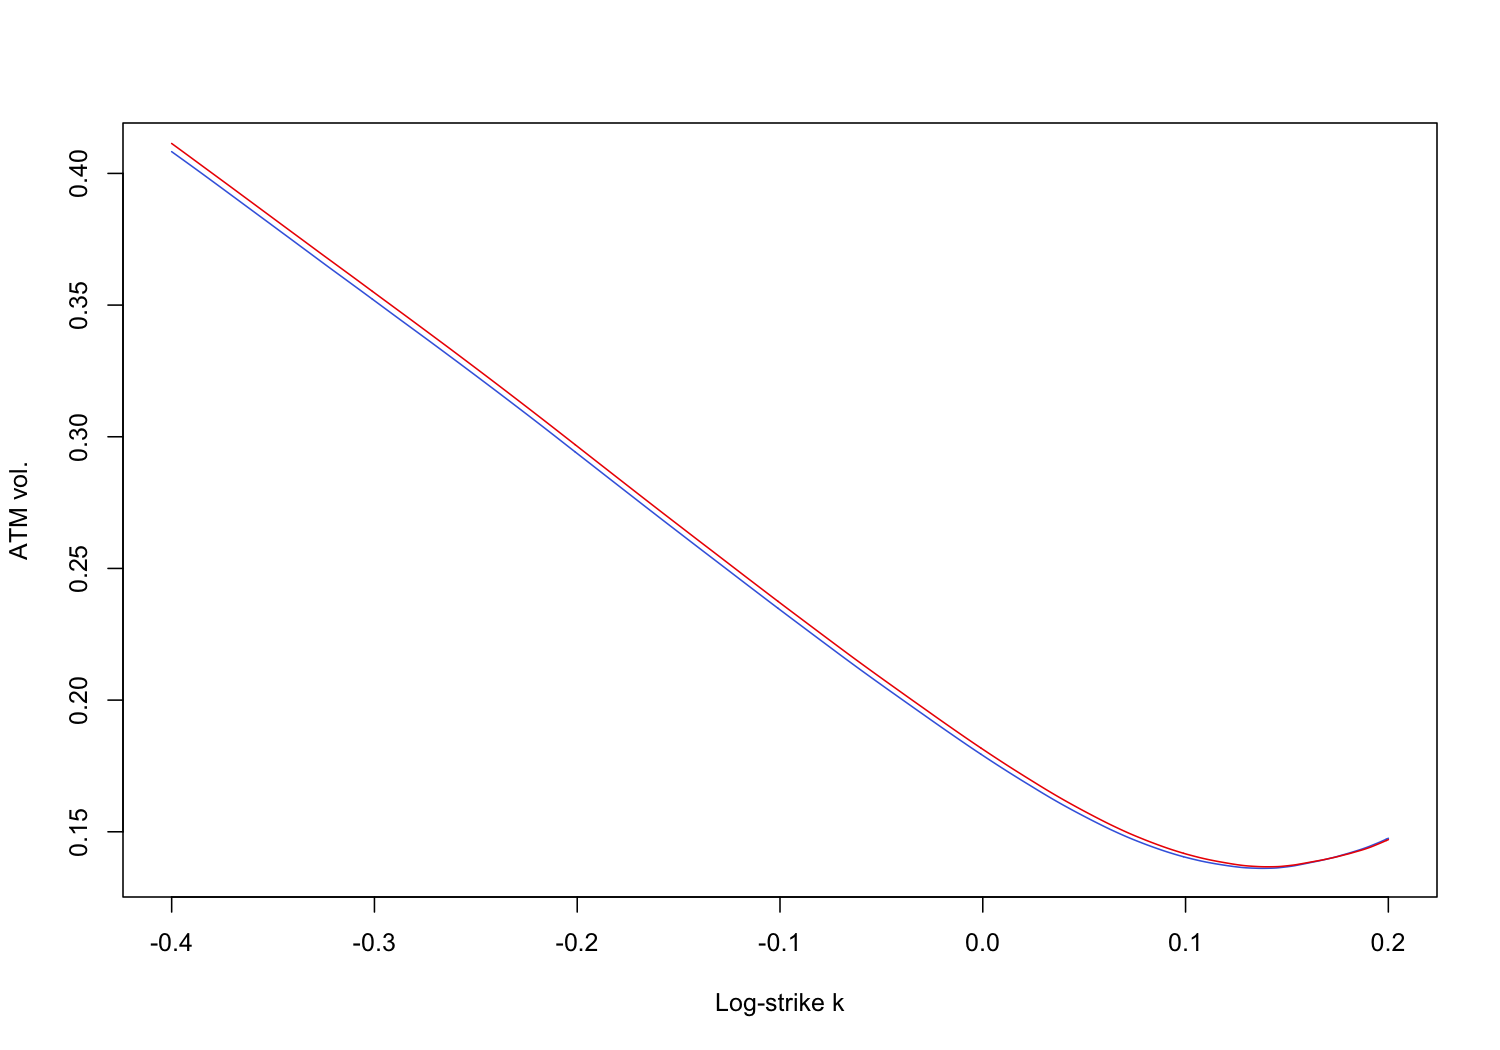

In [18]:
plot(kk, vol.kk, pch = 20, col = bl, type = "l", xlab = "Log-strike k", ylab = "ATM vol.")
lines(kk, vol.h.kk, col = rd)


# Computation of the regression coefficient $\beta$


In [19]:
beta <- numeric(nn)

for (j in 1:nn) {
  beta[j] <- (bsOut(ST.h[j, ], expiries[j], 1)$BSV - bsOut(ST[j, ], expiries[j], 1)$BSV) / .01 / sqrt(expiries[j])
}


# Log-log plot of $\beta_t(T)$


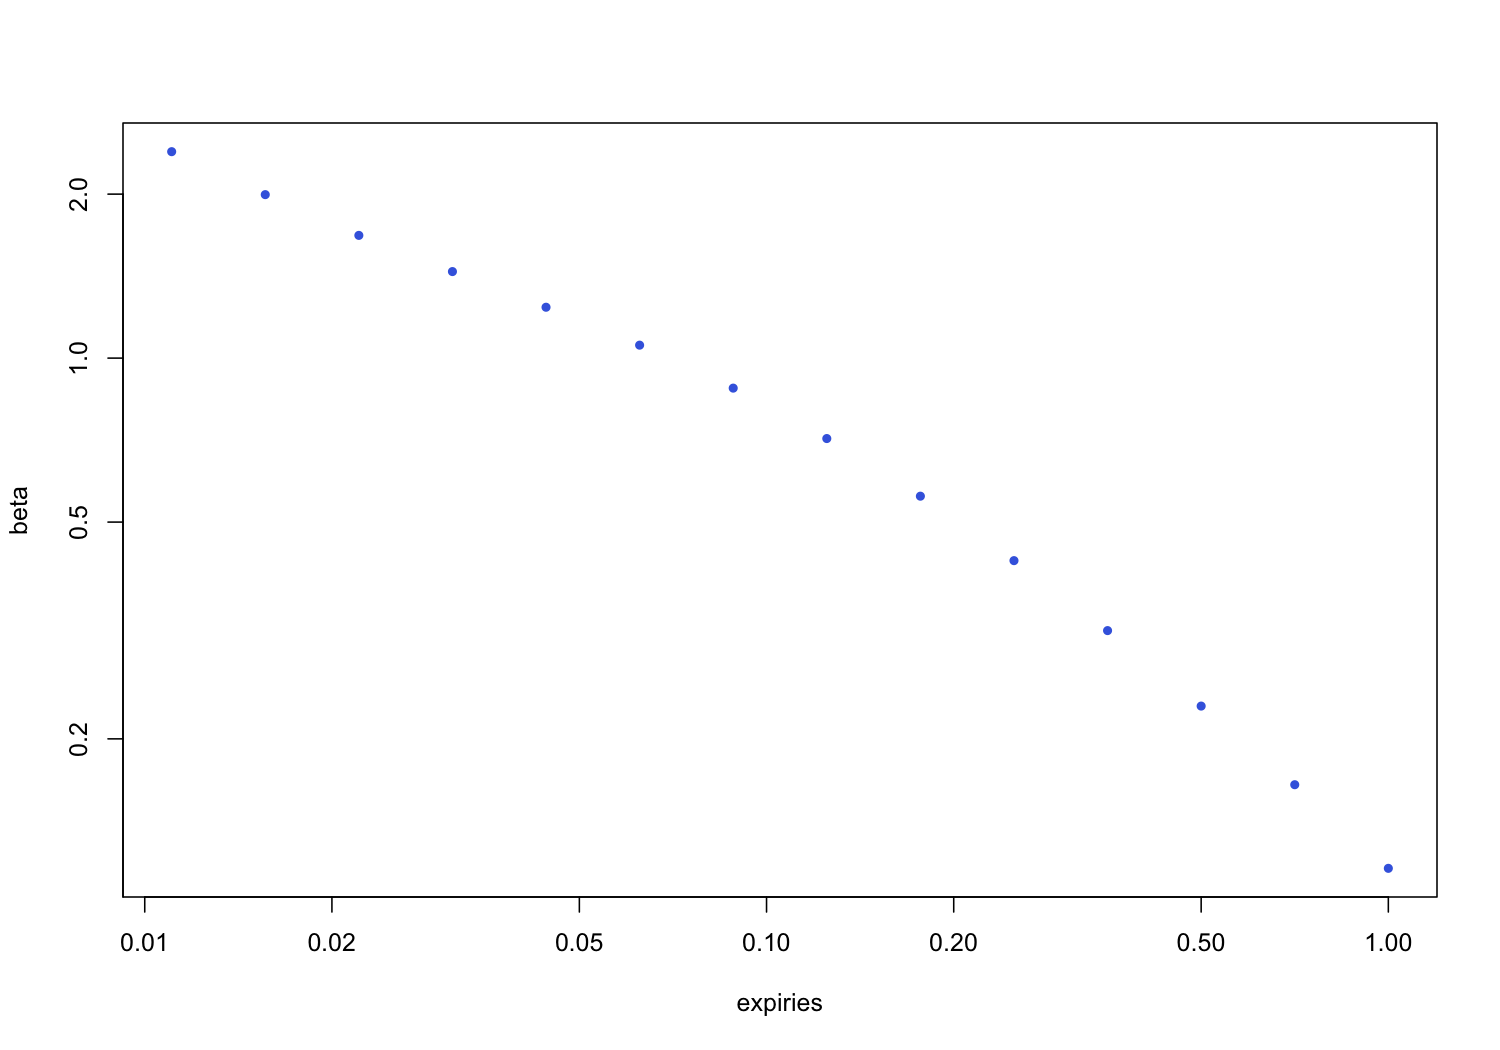

In [20]:
plot(expiries, beta, pch = 20, col = bl, log = "xy")


# Skew computation


We can estimate the ATM skew $\mathcal{S}(T) = \left. \frac{\partial \sigma_{\text{BS}}(k,T)}{\partial k}\right|_{k=0}$ by Monte Carlo using the following implied volatility skew representation, $$ \frac{\partial \sigma_{\text{BS}}(k,T)}{\partial k} = \left. \frac{\Phi\left(-\frac{k}{\sqrt{w}} - \frac{\sqrt{w}}{2}\right) - \mathbb P\left(X_T \geq k\right)}{\sqrt{T} \phi\left(-\frac{k}{\sqrt{w}} - \frac{\sqrt{w}}{2}\right)} \right|_{w=T \sigma_{\text{BS}}^2(k,T)} $$ where $\phi$ is the PDF of a standard normal distribution.


In [21]:
pr <- numeric(nn)
skew <- numeric(nn)
pr.h <- numeric(nn)
skew.h <- numeric(nn)


In [22]:
for (j in 1:nn) {
  Xj <- mcMatrix[4 + 8 * (j - 1), ] - mcMatrix[2 + 8 * (j - 1), ] / 2
  pr[j] <- mean(Xj >= 0)
  Xj <- mcMatrix[8 + 8 * (j - 1), ] - mcMatrix[2 + 8 * (j - 1), ] / 2
  pr.h[j] <- mean(Xj >= 0)
}


In [23]:
for (j in 1:nn) {
  wj <- mean(mcMatrix[2 + 8 * (j - 1), ])
  Phij <- pnorm(-sqrt(wj) / 2)
  phij <- dnorm(-sqrt(wj) / 2)
  skew[j] <- (Phij - pr[j]) / sqrt(expiries[j]) / phij
  wj <- mean(mcMatrix[6 + 8 * (j - 1), ])
  Phij <- pnorm(-sqrt(wj) / 2)
  phij <- dnorm(-sqrt(wj) / 2)
  skew.h[j] <- (Phij - pr[j]) / sqrt(expiries[j]) / phij
}


# Log-log plot of $\mathcal{S}_t(T)$


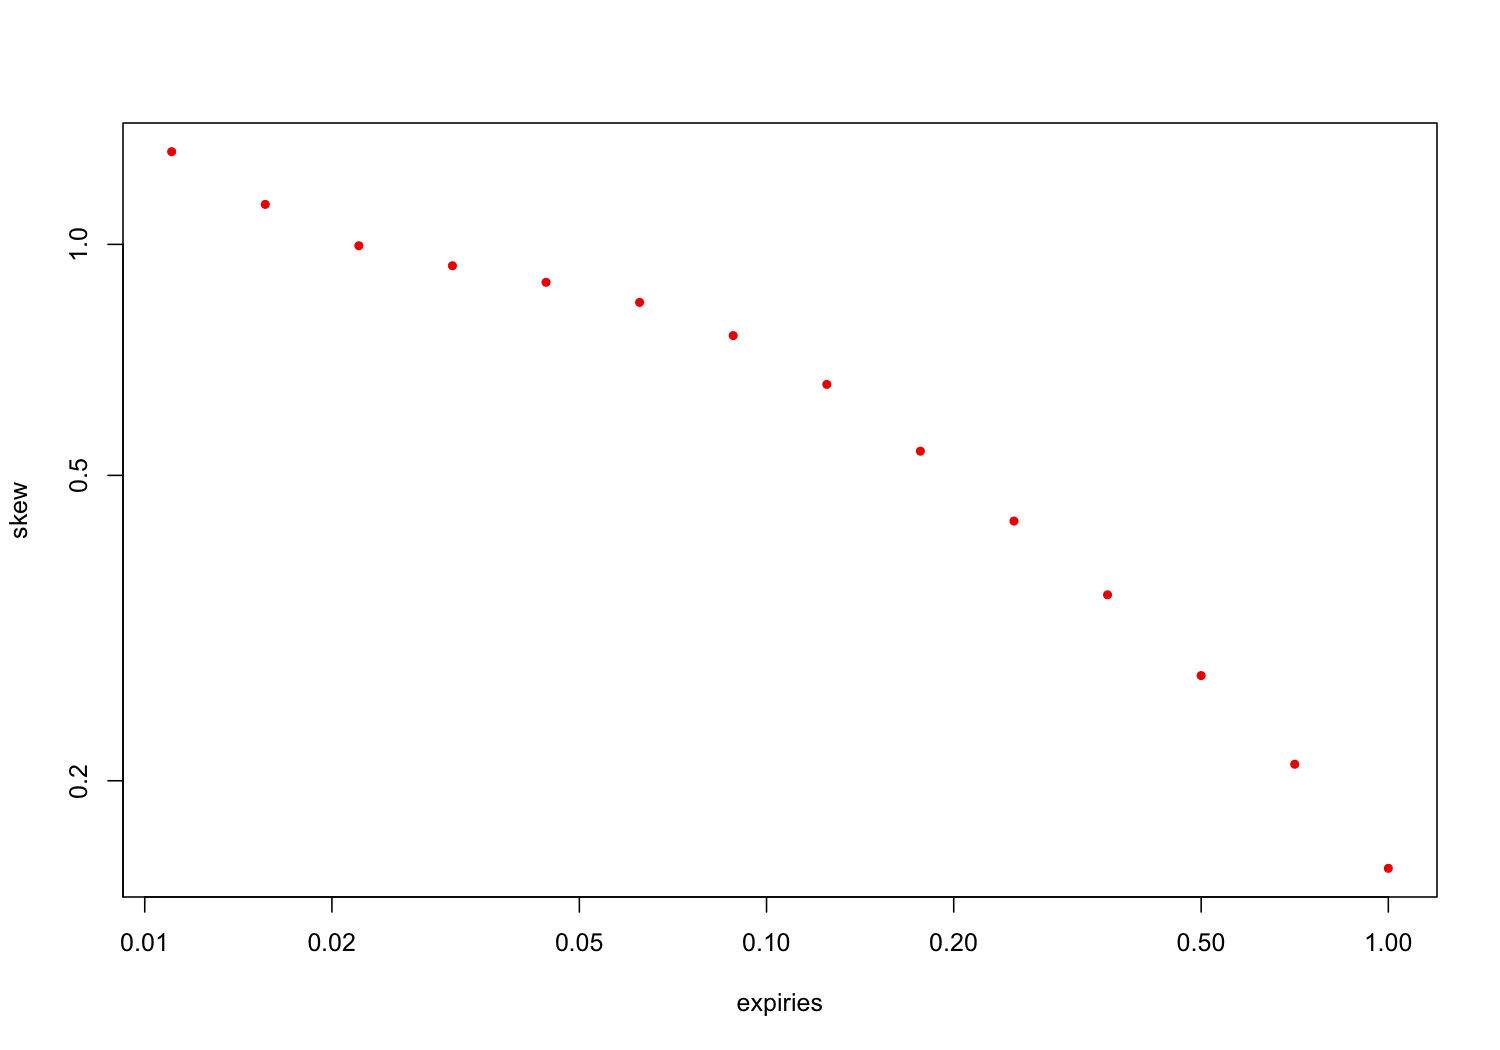

In [24]:
plot(expiries, skew, pch = 20, col = rd, log = "xy")


In [25]:
(ssr <- beta / skew)


[1] 1.8120547 1.7701859 1.6868785 1.5372125 1.3892891 1.2570198 1.1581633
 [8] 1.0833400 1.0375492 0.9744438 0.9045404 0.8377419 0.7839583 0.7523699

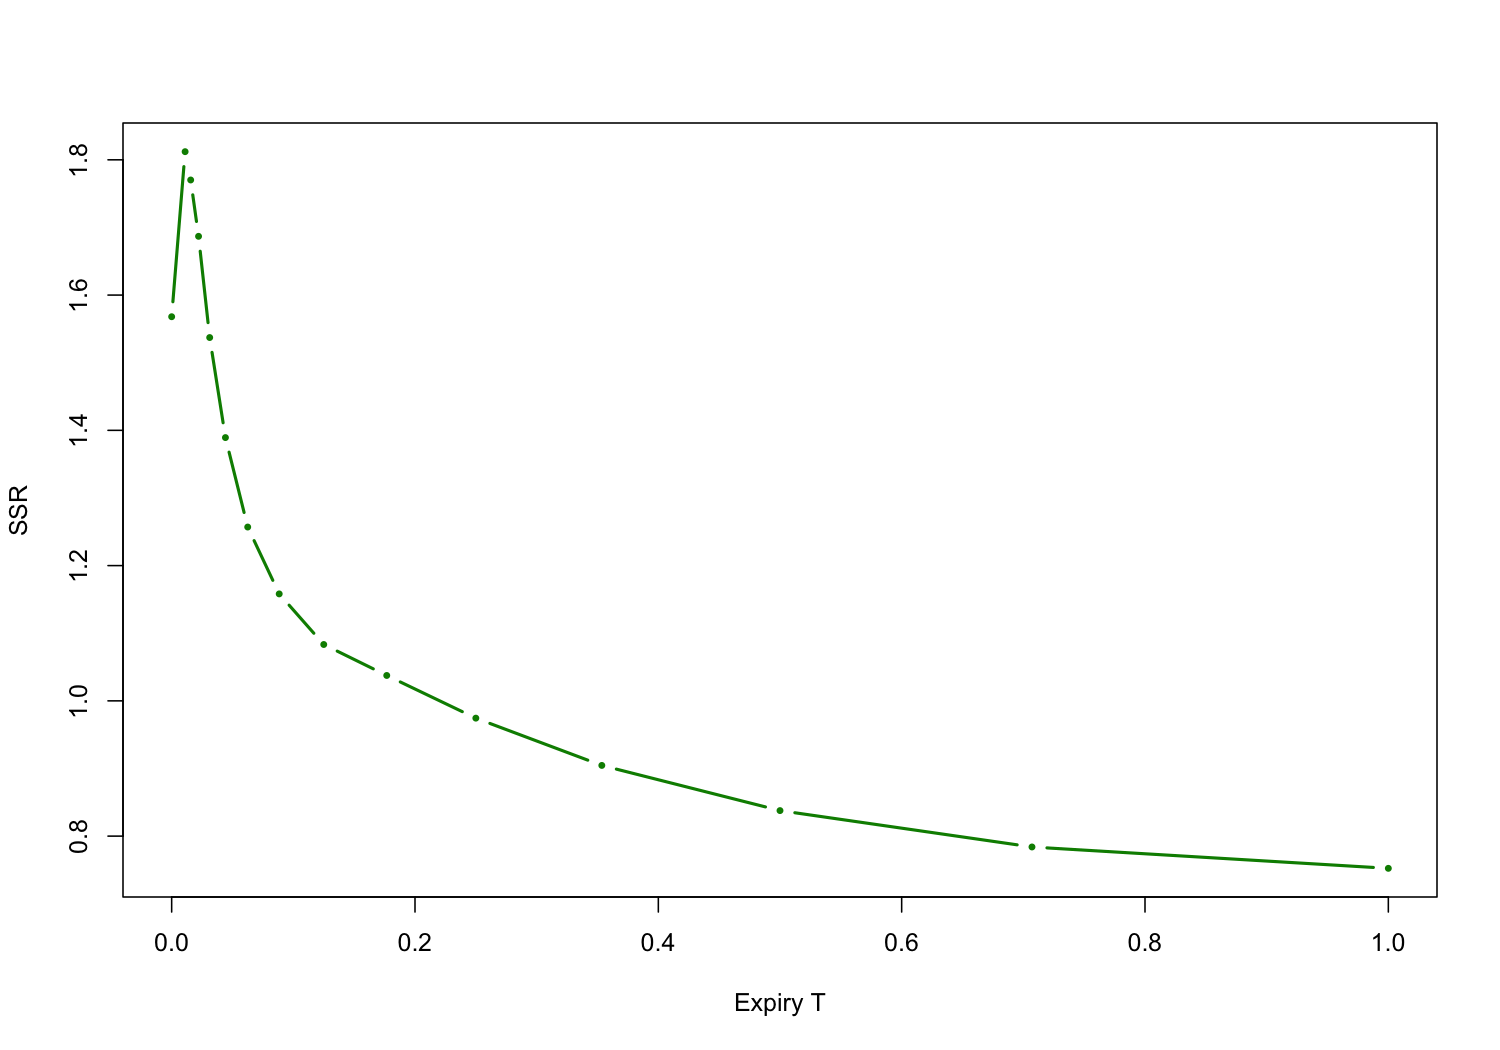

In [26]:
plot(c(0, expiries), c(params0$al + 1, ssr),
  pch = 20, col = gr, type = "b", lwd = 2, cex = .5,
  ylab = "SSR", xlab = "Expiry T"
)
